<a href="https://colab.research.google.com/github/Kanikasr/Stock-Prediction-Regression-Model/blob/main/yes_bank_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name**    -



##### **Project Type**    - EDA/Regression/Classification/Unsupervised
##### **Contribution**    - Individual/Team
##### **Team Member 1 -**
##### **Team Member 2 -**
##### **Team Member 3 -**
##### **Team Member 4 -**

# **Project Summary -**

Write the summary here within 500-600 words.

# **GitHub Link -**

Provide your GitHub Link here.

# **Problem Statement**


**Write Problem Statement Here.**

# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [4]:
# ---------------------------
# 0. Setup / imports (run once)
# ---------------------------
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [36]:
# ---------------------------
# 1. Load raw CSV
# ---------------------------
file_path = "/content/drive/My Drive/projects/yes_bank/data_YesBank_StockPrices.csv"
raw = pd.read_csv(file_path, dtype=str)
raw.columns = raw.columns.str.strip()
raw = raw.dropna(how='all')

expected = ['Date', 'Open', 'High', 'Low', 'Close']
missing = [c for c in expected if c not in raw.columns]
if missing:
    raise RuntimeError(f"Missing columns: {missing}")

for col in ['Open','High','Low','Close']:
    raw[col] = raw[col].astype(str).str.replace(',', '').str.strip()
    raw[col] = pd.to_numeric(raw[col], errors='coerce')

try:
    raw['Date'] = pd.to_datetime(raw['Date'], format='%b-%y', errors='raise')
except:
    raw['Date'] = pd.to_datetime(raw['Date'], errors='coerce')

clean = raw.dropna(subset=['Date','Close']).copy()
clean['Date'] = clean['Date'].dt.to_period('M').dt.to_timestamp()
clean = clean.sort_values('Date').drop_duplicates(subset=['Date'])
clean.set_index('Date', inplace=True)
clean.reset_index().to_csv("data.csv", index=False)

ts = clean['Close']


In [37]:
# ---------------------------
# 2. Stationarity check
# ---------------------------
adf = adfuller(ts.dropna())
print("ADF:", adf[0], "p-value:", adf[1])

clean['Log_Close'] = np.log(clean['Close'])
clean['Log_Close_diff'] = clean['Log_Close'].diff()
adf2 = adfuller(clean['Log_Close_diff'].dropna())
print("ADF log-diff p-value:", adf2[1])


ADF: -1.906409141172657 p-value: 0.3290520815004394
ADF log-diff p-value: 1.286111282973521e-21


In [38]:
# ---------------------------
# 3. ARIMA model
# ---------------------------
horizon = 12
train_ts = ts.iloc[:-horizon].copy()
test_ts = ts.iloc[-horizon:].copy()

arima_order = (1,1,1)
arima_model = ARIMA(train_ts, order=arima_order).fit()

# Forecast test
fc_test = arima_model.forecast(steps=horizon)
fc_test.index = test_ts.index

mae = mean_absolute_error(test_ts, fc_test)
rmse = np.sqrt(mean_squared_error(test_ts, fc_test))
mape = np.mean(np.abs((test_ts - fc_test) / test_ts))*100
print("ARIMA Test Performance — MAE:", mae, "RMSE:", rmse, "MAPE:", mape)

# Full dataset forecast
arima_full = ARIMA(ts, order=arima_order).fit()
future_steps = 12
future_fc = arima_full.forecast(steps=future_steps)
future_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthBegin(), periods=future_steps, freq='MS')
future_fc.index = future_index

ARIMA Test Performance — MAE: 44.87397191774255 RMSE: 46.20023802142884 MAPE: 251.06629348161422


In [39]:
# ---------------------------
# 4. Feature engineering for ML
# ---------------------------
df = clean.copy()
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Range'] = (df['High'] - df['Low']) if 'High' in df.columns and 'Low' in df.columns else df['Close'].rolling(3).std().fillna(0.0)
df['Lag1'] = df['Close'].shift(1)
df['Lag2'] = df['Close'].shift(2)
df['RollMean3'] = df['Close'].rolling(3).mean()
df = df.dropna()

train_ml = df.iloc[:-horizon].copy()
test_ml = df.iloc[-horizon:].copy()

features = ['Month','Year','Range','Lag1','Lag2','RollMean3']
X_train = train_ml[features]
y_train = train_ml['Close']
X_test = test_ml[features]
y_test = test_ml['Close']

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)


In [40]:
# ---------------------------
# 5. Train ML models
# ---------------------------
models = {}
models['Linear'] = LinearRegression()
models['RandomForest'] = RandomForestRegressor(n_estimators=200, random_state=42)
try:
    from xgboost import XGBRegressor
    models['XGBoost'] = XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=42)
except:
    pass
models['SVR'] = SVR(kernel='rbf')

results = []
predictions = {}

for name, mdl in models.items():
    try:
        mdl.fit(X_train_scaled.values, y_train.values)
        preds = mdl.predict(X_test_scaled.values)
        predictions[name] = preds
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mape = np.mean(np.abs((y_test - preds)/y_test))*100
        results.append([name, mae, rmse, mape])
    except:
        continue

results_df = pd.DataFrame(results, columns=['Model','MAE','RMSE','MAPE (%)']).set_index('Model')
allowed = ['RandomForest', 'XGBoost']  # ignore LinearRegression
available = [m for m in allowed if m in results_df.index]
best_ml_name = results_df.loc[available]['RMSE'].idxmin()
best_ml = models[best_ml_name]



In [41]:

# ARIMA predictions on the *train* window, then residuals = actual - arima_pred
arima_pred_train = arima_model.predict(start=train_ts.index[0], end=train_ts.index[-1])
residuals = train_ts - arima_pred_train  # length = len(train_ts)

# Align residuals with ML feature rows (train_ml drops the first 2 rows due to Lag1/Lag2)
# So we just take the *last len(train_ml)* residuals
residuals_aligned = residuals.tail(len(train_ml))

# Build residual training frame
train_ml_resid = train_ml.copy()                # has Month/Year/Range/Lag1/Lag2/RollMean3
train_ml_resid['Residual'] = residuals_aligned.values

# Train a model to predict residuals from the same feature set
X_resid = train_ml_resid[features]
y_resid = train_ml_resid['Residual']

scaler_resid = StandardScaler()
X_resid_scaled = scaler_resid.fit_transform(X_resid)

rf_resid = RandomForestRegressor(n_estimators=200, random_state=42)
rf_resid.fit(X_resid_scaled, y_resid)


RandomForestRegressor(n_estimators=200, random_state=42)

In [42]:
def hybrid_forecast(steps=12):
    """
    Returns:
      future_ml (pd.Series), future_hybrid (pd.Series), future_arima (pd.Series)
    """
    # ----- Dates for the horizon -----
    future_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(), periods=steps, freq='MS')

    # ----- ARIMA mean forecast for the same horizon -----
    future_arima = arima_full.forecast(steps=steps)
    future_arima.index = future_dates

    # We’ll need a stable 'Range' value for future rows (use last observed)
    last_range = float(df['Range'].iloc[-1])

    # ===== Step 1: ML trend (recursive with its own lags) =====
    last_close_ml = df['Close'].iloc[-2:].tolist()
    future_ml_vals = []

    base_row_ml = df[features].iloc[-1:].copy()
    for dt in future_dates:
        lag1 = last_close_ml[-1]
        lag2 = last_close_ml[-2]
        rollmean3 = np.mean([lag1, lag2, lag1])

        row = base_row_ml.copy()
        row.loc[row.index[0], 'Lag1'] = lag1
        row.loc[row.index[0], 'Lag2'] = lag2
        row.loc[row.index[0], 'RollMean3'] = rollmean3
        row.loc[row.index[0], 'Month'] = dt.month
        row.loc[row.index[0], 'Year']  = dt.year
        row.loc[row.index[0], 'Range'] = last_range

        scaled = scaler.transform(row[features])
        ml_pred = best_ml.predict(scaled)[0]
        future_ml_vals.append(ml_pred)

        # update ML lags
        last_close_ml.append(ml_pred)
        last_close_ml.pop(0)

    future_ml = pd.Series(future_ml_vals, index=future_dates)

    # ===== Step 2: Residual forecast (recursive, driven by last *hybrid* closes) =====
    # Start hybrid lags with last two actual closes
    last_close_hybrid = df['Close'].iloc[-2:].tolist()
    future_resid_vals = []

    base_row_resid = df[features].iloc[-1:].copy()
    for dt, arima_mean in zip(future_dates, future_arima.values):
        # build residual features using last *hybrid* closes
        lag1_h = last_close_hybrid[-1]
        lag2_h = last_close_hybrid[-2]
        rollmean3_h = np.mean([lag1_h, lag2_h, lag1_h])

        row_resid = base_row_resid.copy()
        row_resid.loc[row_resid.index[0], 'Lag1'] = lag1_h
        row_resid.loc[row_resid.index[0], 'Lag2'] = lag2_h
        row_resid.loc[row_resid.index[0], 'RollMean3'] = rollmean3_h
        row_resid.loc[row_resid.index[0], 'Month'] = dt.month
        row_resid.loc[row_resid.index[0], 'Year']  = dt.year
        row_resid.loc[row_resid.index[0], 'Range'] = last_range

        scaled_r = scaler_resid.transform(row_resid[features])
        resid_pred = rf_resid.predict(scaled_r)[0]
        future_resid_vals.append(resid_pred)

        # compute current hybrid to update lags for next step
        hybrid_now = arima_mean + resid_pred
        last_close_hybrid.append(hybrid_now)
        last_close_hybrid.pop(0)

    future_resid = pd.Series(future_resid_vals, index=future_dates)

    # ===== Step 3: Hybrid = ARIMA mean + predicted residual =====
    future_hybrid = future_arima.values + future_resid.values
    future_hybrid = pd.Series(future_hybrid, index=future_dates)

    # ===== Print table nicely for copy-paste + save CSV =====
    print("Date\t\tARIMA\t\tML\t\tHybrid")
    for dt, a, m, h in zip(future_dates, future_arima.values, future_ml.values, future_hybrid.values):
        print(f"{dt.date()}\t{a:.4f}\t{m:.4f}\t{h:.4f}")

    out = pd.DataFrame({
        "Date": future_dates,
        "ARIMA": future_arima.values,
        f"{best_ml_name}": future_ml.values,
        "Hybrid": future_hybrid.values
    })
    out.to_csv(f"forecast_{steps}mo.csv", index=False)
    print(f"\nSaved forecast_{steps}mo.csv")

    return future_ml, future_hybrid, future_arima


In [44]:
ml_12, hybrid_12, arima_12 = hybrid_forecast(steps=12)
ml_24, hybrid_24, arima_24 = hybrid_forecast(steps=24)
ml_36, hybrid_36, arima_36 = hybrid_forecast(steps=36)


Date		ARIMA		ML		Hybrid
2020-12-01	13.7183	14.7765	14.2055
2021-01-01	14.4954	14.4517	14.7408
2021-02-01	13.8609	13.5130	14.1159
2021-03-01	14.3790	12.7814	14.9666
2021-04-01	13.9560	13.4955	14.2864
2021-05-01	14.3014	13.3733	14.3113
2021-06-01	14.0193	13.4981	13.9035
2021-07-01	14.2496	13.5092	14.4157
2021-08-01	14.0616	13.5873	14.2128
2021-09-01	14.2151	13.5291	14.2897
2021-10-01	14.0898	13.5128	14.3886
2021-11-01	14.1921	13.5201	14.5685

Saved forecast_12mo.csv
Date		ARIMA		ML		Hybrid
2020-12-01	13.7183	14.7765	14.2055
2021-01-01	14.4954	14.4517	14.7408
2021-02-01	13.8609	13.5130	14.1159
2021-03-01	14.3790	12.7814	14.9666
2021-04-01	13.9560	13.4955	14.2864
2021-05-01	14.3014	13.3733	14.3113
2021-06-01	14.0193	13.4981	13.9035
2021-07-01	14.2496	13.5092	14.4157
2021-08-01	14.0616	13.5873	14.2128
2021-09-01	14.2151	13.5291	14.2897
2021-10-01	14.0898	13.5128	14.3886
2021-11-01	14.1921	13.5201	14.5685
2021-12-01	14.1085	13.6484	14.5218
2022-01-01	14.1768	13.5089	14.4181
2022-02-01	14.121

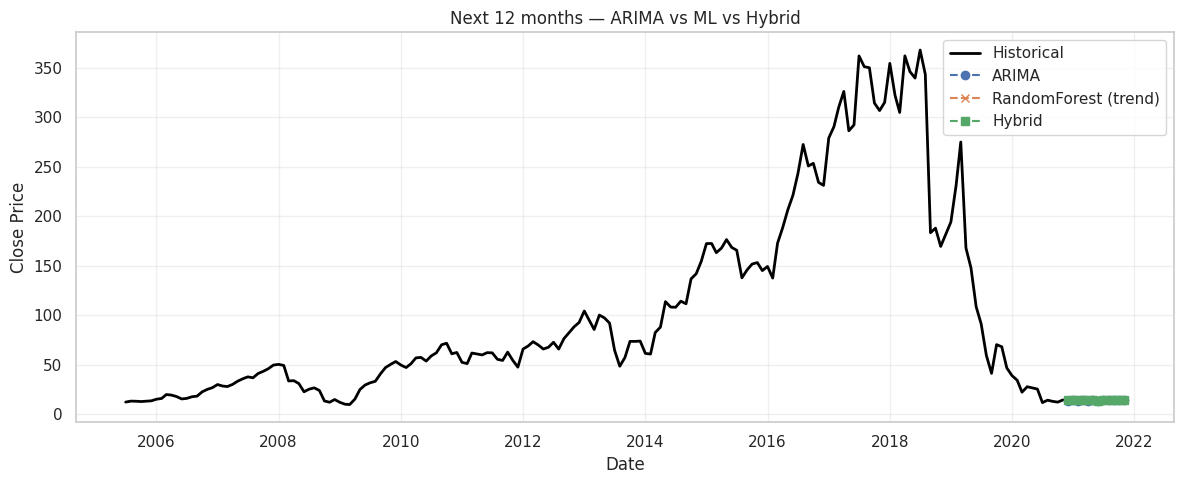

In [30]:
def plot_comp(ts, arima_series, ml_series, hybrid_series, title):
    plt.figure(figsize=(12,5))
    plt.plot(ts, label='Historical', color='black', linewidth=2)
    plt.plot(arima_series.index, arima_series.values, '--o', label='ARIMA')
    plt.plot(ml_series.index, ml_series.values, '--x', label=f'{best_ml_name} (trend)')
    plt.plot(hybrid_series.index, hybrid_series.values, '--s', label='Hybrid')
    plt.title(title)
    plt.xlabel('Date'); plt.ylabel('Close Price')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
    plt.show()

plot_comp(ts, arima_12, ml_12, hybrid_12, 'Next 12 months — ARIMA vs ML vs Hybrid')


In [34]:
import joblib, os, json

os.makedirs("/content/models", exist_ok=True)

# Save ARIMA
joblib.dump(arima_full, "/content/models/arima_model.pkl")

# Save ML model
joblib.dump(best_ml, "/content/models/best_ml_model.pkl")
joblib.dump(scaler, "/content/models/scaler.pkl")

# Save Residual model
joblib.dump(rf_resid, "/content/models/rf_resid.pkl")
joblib.dump(scaler_resid, "/content/models/scaler_resid.pkl")

# Save features list
json.dump(features, open("/content/models/features.json","w"))

# Save cleaned df
clean.reset_index().to_csv("/content/models/data.csv", index=False)

print("✅ All models saved to /content/models")


✅ All models saved to /content/models


In [35]:
# # In a Colab cell AFTER training/saving:
# from google.colab import files
# files.download("/content/models/arima_model.pkl")
# files.download("/content/models/best_ml_model.pkl")
# files.download("/content/models/rf_resid.pkl")
# files.download("/content/models/scaler.pkl")
# files.download("/content/models/scaler_resid.pkl")
# files.download("/content/models/features.json")
# files.download("/content/models/data.csv")

from google.colab import files
for f in os.listdir("/content/models"):
    files.download("/content/models/" + f)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Conclusion**

Write the conclusion here.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***